In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-prediction-dataset/data_descriptions.csv
/kaggle/input/churn-prediction-dataset/train.csv
/kaggle/input/churn-prediction-dataset/test.csv


Import libraries
-

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample

Load and prepare the dataset
-

In [28]:
df = pd.read_csv("/kaggle/input/churn-prediction-dataset/train.csv")

print(df.head())

# Drop CustomerID since it's just an identifier
df = df.drop(columns=['CustomerID'], errors='ignore')

X = df.drop(columns=['Churn'])
y = df['Churn']

   AccountAge  MonthlyCharges  TotalCharges SubscriptionType  \
0          20       11.055215    221.104302          Premium   
1          57        5.175208    294.986882            Basic   
2          73       12.106657    883.785952            Basic   
3          32        7.263743    232.439774            Basic   
4          57       16.953078    966.325422          Premium   

      PaymentMethod PaperlessBilling ContentType MultiDeviceAccess  \
0      Mailed check               No        Both                No   
1       Credit card              Yes      Movies                No   
2      Mailed check              Yes      Movies                No   
3  Electronic check               No    TV Shows                No   
4  Electronic check              Yes    TV Shows                No   

  DeviceRegistered  ViewingHoursPerWeek  ...  ContentDownloadsPerMonth  \
0           Mobile            36.758104  ...                        10   
1           Tablet            32.450568  ...  

Balance the data
-

In [31]:
train_data = pd.concat([X_train, y_train], axis=1)
majority = train_data[train_data.Churn == 0]
minority = train_data[train_data.Churn == 1]
minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

train_balanced = pd.concat([majority, minority_upsampled])
X_train = train_balanced.drop('Churn', axis=1)
y_train = train_balanced['Churn']

In [32]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.select_dtypes(exclude=['object']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ]
)

In [38]:
mlp = MLPClassifier(hidden_layer_sizes=(100, 50),
                    activation='relu',
                    solver='adam',
                    learning_rate_init=0.001,
                    max_iter=1000,
                    random_state=42,
                   early_stopping=True)

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('classifier', mlp)
])

Train MLP model
-

In [39]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['AccountAge', 'MonthlyCharges', 'TotalCharges', 'ViewingHoursPerWeek',
       'AverageViewingDuration', 'ContentDownloadsPerMonth', 'UserRating',
       'SupportTicketsPerMonth', 'WatchlistSize'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['SubscriptionType', 'PaymentMethod', 'PaperlessBilling', 'ContentType',
       'MultiDeviceAccess', 'DeviceRegistered', 'GenrePreference', 'Gender',
       'ParentalControl', 'SubtitlesEnabled'],
      dtype='object'))])),
                ('classifier',
                 MLPClassifier(early_stopping=True,
                               hidden_layer_sizes=(100, 50), max_iter=1000,
                               random_state=42))])

Evaluation
-

In [42]:
y_pred = (model.predict(X_test)>= 0.5).astype(int)

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Model Accuracy: 0.6558513474711842

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.66      0.76     39921
           1       0.30      0.65      0.41      8837

    accuracy                           0.66     48758
   macro avg       0.60      0.66      0.58     48758
weighted avg       0.79      0.66      0.69     48758


Confusion Matrix:
 [[26201 13720]
 [ 3060  5777]]


Tune threshold for increasing recall
-

In [44]:
from sklearn.metrics import precision_score, recall_score

# Lấy xác suất của class 1 (churn)
y_proba = model.predict_proba(X_test)[:, 1]

thresholds = [0.5, 0.4, 0.3, 0.2]

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f"Threshold={t:.2f} | Recall={recall:.3f} | Precision={precision:.3f}")

Threshold=0.50 | Recall=0.654 | Precision=0.296
Threshold=0.40 | Recall=0.743 | Precision=0.270
Threshold=0.30 | Recall=0.824 | Precision=0.249
Threshold=0.20 | Recall=0.889 | Precision=0.229


Precision-recall diagram
-

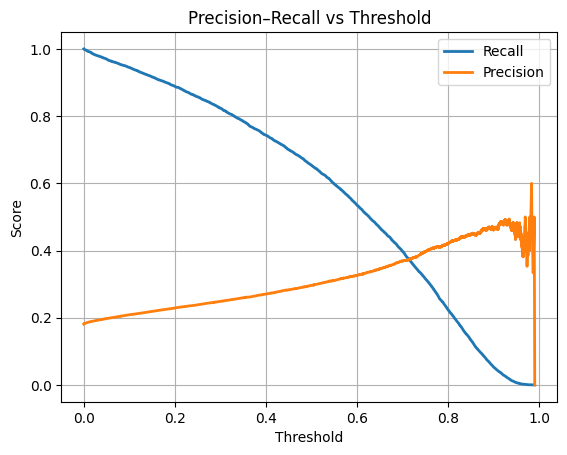

In [45]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(thresholds, recall[:-1], label='Recall', lw=2)
plt.plot(thresholds, precision[:-1], label='Precision', lw=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision–Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()